In [1]:
%matplotlib inline
import math
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
from PIL import Image
import os
import matplotlib.pylab as plt
from tqdm import tqdm
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import sparse
from subprocess import check_output
from keras.models import load_model
import keras
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Activation, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

/home/adityasidharta/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
img_size = (200, 300, 1)

In [3]:
train_df = pd.read_csv('train.csv')
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [4]:
train_filename =  train_df.Image.values
test_filename = os.listdir('test')
n_train = len(os.listdir('train'))
n_test = len(os.listdir('test'))
print n_train
print n_test

9850
15610


In [5]:
sample_test_img =  os.listdir('test')[:20]

In [6]:
n_unique = len(train_df['Id'].unique())
print "Number of Unique Categories : " + str(n_unique)

Number of Unique Categories : 4251


In [7]:
weight_series = train_df['Id'].value_counts()
weight_df = pd.DataFrame(weight_series)
weight_df.columns = ['count']
weight_df['count'] = weight_df['count'].astype(float)
weight_df['Id'] = weight_df.index
weight_df = weight_df.reset_index(drop = True)
weight_df['weight'] = n_train / (n_unique * weight_df['count'] )
weight_df

,count,Id,weight
0,810.0,new_whale,0.002861
1,34.0,w_1287fbc,0.068150
2,27.0,w_98baff9,0.085819
3,26.0,w_7554f44,0.089119
4,23.0,w_1eafe46,0.100744
5,22.0,w_693c9ee,0.105323
6,22.0,w_fd1cb9d,0.105323
7,22.0,w_ab4cae2,0.105323
8,21.0,w_43be268,0.110338
9,21.0,w_73d5489,0.110338


In [8]:
train_df = train_df.merge(weight_df, on='Id')

In [9]:
def plot_images(filenames, table_size, labels = '', traintest = 'train'):
    imgs_filename = [traintest + '/' + str(filename) for filename in filenames]
    imgs = [plt.imread(filename) for filename in imgs_filename]
    figure = plt.figure(figsize=(20, 10))
    rows, cols = table_size
    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if not np.all(labels == ''):
            subplot.set_title(labels[i], fontsize=10)
        subplot.imshow(imgs[i], cmap='gray')
    plt.tight_layout()
    plt.show()

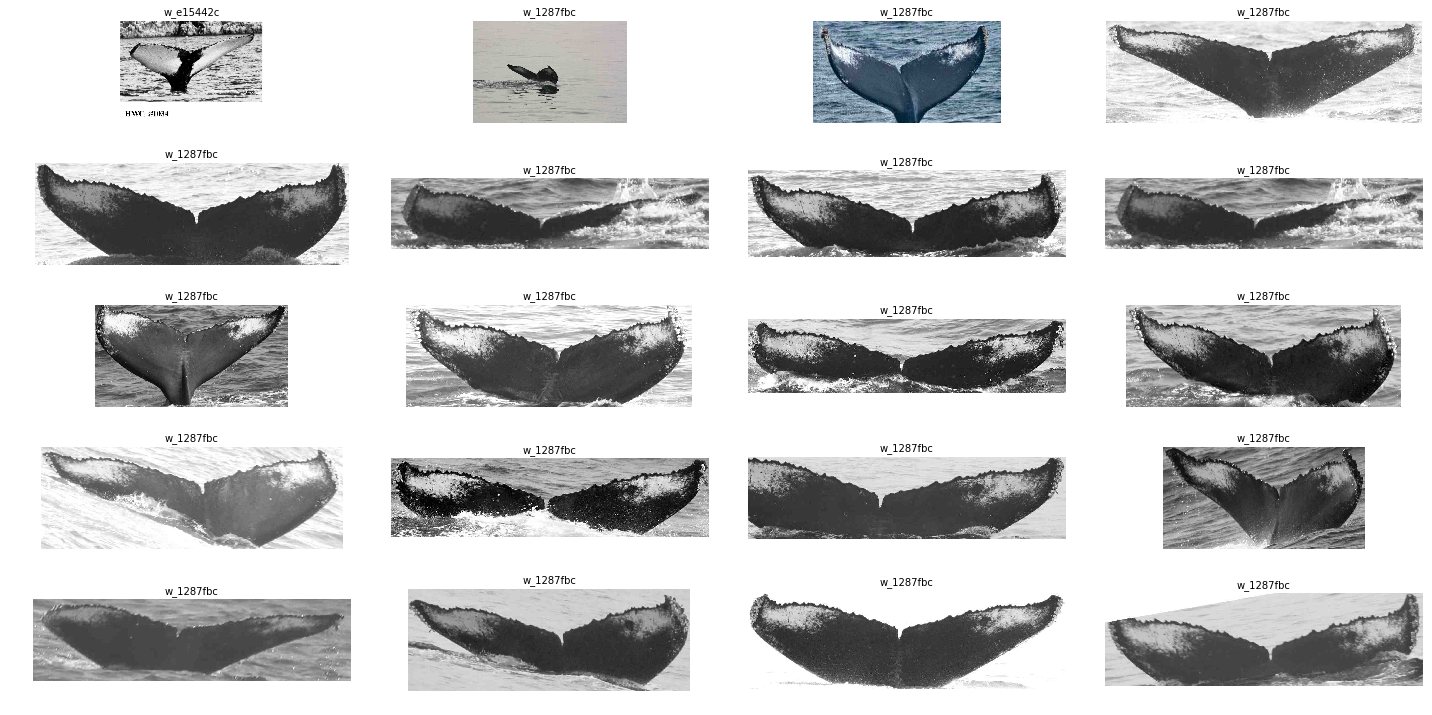

In [12]:
plot_images(train_df.Image[:20], (5,4) ,train_df.Id[:20], 'train')

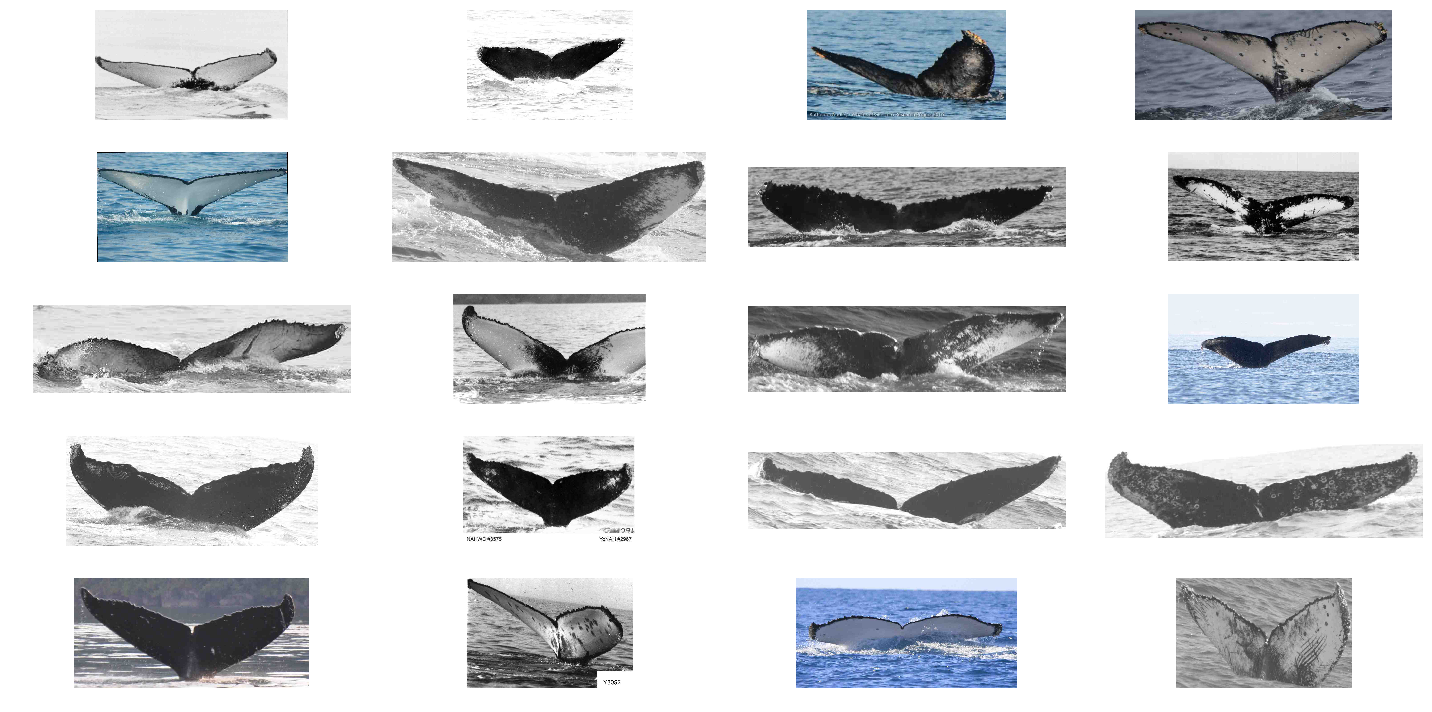

In [13]:
plot_images(sample_test_img, (5,4), '', 'test')

Text(0.5,1,u'Number of images within category')

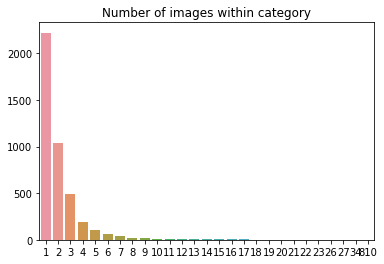

In [14]:
count_categories = dict(Counter(train_df['Id'].value_counts().values))
sns.barplot(count_categories.keys(),count_categories.values()).set_title('Number of images within category')

In [15]:
train_filename = ['train/'+ filename for filename in train_filename]
test_filename = ['test/'+ filename for filename in test_filename]

In [16]:
train_img_sizes = [Image.open(image).size for image in train_filename]
count_train_img_sizes = Counter(train_img_sizes)
test_img_sizes = [Image.open(image).size for image in test_filename]
count_test_train_img_sizes = Counter(test_img_sizes)

In [17]:
print min(train_img_sizes)
print min(test_img_sizes)

(64, 30)
(138, 79)


In [18]:
len([1 for imgsize in count_train_img_sizes if (imgsize[0] < 600) and (imgsize[1] < 400)])

343

In [19]:
print count_train_img_sizes.most_common(10)
print count_test_train_img_sizes.most_common(10)

[((1050, 600), 1113), ((1050, 700), 951), ((1050, 450), 409), ((1050, 525), 371), ((700, 500), 200), ((1000, 667), 122), ((1050, 630), 114), ((1000, 652), 85), ((900, 600), 72), ((1050, 599), 44)]
[((1050, 600), 2065), ((1050, 700), 1296), ((1050, 450), 678), ((700, 500), 664), ((1050, 525), 374), ((1000, 667), 174), ((1050, 630), 171), ((1000, 652), 139), ((700, 400), 107), ((1050, 750), 81)]


In [20]:
df_label = pd.get_dummies(train_df.Id.values)
Y_train = sparse.csc_matrix(df_label.values)
Y_label = df_label.columns

In [21]:
def convert_img(filename):
    img = Image.open(filename).convert("LA").resize((img_size[1],img_size[0]))
    return np.array(img)[:,:,0]

In [ ]:
X_train = np.zeros((n_train, img_size[0], img_size[1], 1))
for idx in tqdm(range(n_train)):
    X_train[idx, :, :, :] = convert_img(train_filename[idx]).reshape(1, img_size[0], img_size[1], img_size[2])

In [132]:
X_train_label = np.array(train_filename)
X_train_weight = np.array(train_df.weight)

In [133]:
X_train_weight

array([2.31710186, 0.06815005, 0.06815005, ..., 2.31710186, 2.31710186,
       2.31710186])

In [ ]:
joblib.dump(X_train, 'X_train.pkl')
joblib.dump(X_train_weight, 'X_train_weight.pkl')
joblib.dump(Y_train, 'Y_train.pkl')
joblib.dump(Y_label, 'Y_label.pkl')

In [10]:
X_train = joblib.load( 'X_train.pkl')
X_train_weight = joblib.load( 'X_train_weight.pkl')
Y_train = joblib.load('Y_train.pkl')
Y_label = joblib.load('Y_label.pkl')

In [155]:
print X_train.shape
print X_train_weight.shape
print Y_train.shape
print Y_label.shape

(9850, 200, 300, 1)
(9850,)
(9850, 4251)
(4251,)


In [156]:
train_imagegen = ImageDataGenerator(
    rescale=1./255.,
    rotation_range=15,
    width_shift_range=.15,
    height_shift_range=.15,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode = 'nearest',
    horizontal_flip=True)

test_imagegen = ImageDataGenerator(rescale = 1./255)

In [157]:
n_unique = 4251

inputs = Input(shape = (img_size[0], img_size[1], img_size[2]), name='Input')

X = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(inputs)
X = BatchNormalization(name = 'BN1_1')(X)
X = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_2')(X)
X = BatchNormalization(name = 'BN1_2')(X)
X = MaxPooling2D((2, 2), strides=(2, 2), name='pool1')(X)

X = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_1')(X)
X = BatchNormalization(name = 'BN2_1')(X)
X = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv2_2')(X)
X = BatchNormalization(name = 'BN2_2')(X)
X = MaxPooling2D((2, 2), strides=(2, 2), name='pool2')(X)

X = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_1')(X)
X = BatchNormalization(name = 'BN3_1')(X)
X = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv3_2')(X)
X = BatchNormalization(name = 'BN3_2')(X)
X = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(X)

X = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4_1')(X)
X = BatchNormalization(name = 'BN4_1')(X)
X = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv4_2')(X)
X = BatchNormalization(name = 'BN4_2')(X)
X = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(X)

X = Flatten(name='flatten')(X)
X = Dense(100, activation='relu', name='fc1')(X)
X = Dense(n_unique, activation='softmax', name='predictions')(X)

nn_model = Model(inputs, X, name='nn_model')
nn_model.compile('adam', 'categorical_crossentropy', ['accuracy', 'top_k_categorical_accuracy'])
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200, 300, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 200, 300, 64)      640       
_________________________________________________________________
BN1_1 (BatchNormalization)   (None, 200, 300, 64)      256       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 200, 300, 64)      36928     
_________________________________________________________________
BN1_2 (BatchNormalization)   (None, 200, 300, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 150, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 100, 150, 64)      36928     
__________

In [158]:
epochs = 2
batch_size = 9850

In [ ]:
idx = np.arange(len(X_train))
for epoch in range(epochs):
    print'Epoch : '+ str(epoch)
    batches = 0
    np.random.shuffle(idx)
    X_train_copy = X_train[idx, :, :, :]
    Y_train_copy = Y_train[idx, :]
    X_train_weight_copy = X_train_weight[idx]
    for X_batch in train_imagegen.flow(X_train_copy, batch_size=batch_size, shuffle = False):
        Y_batch = Y_train_copy[batches * batch_size : (batches+1) * batch_size].toarray()
        X_batch_weight = X_train_weight_copy[batches * batch_size : (batches+1) * batch_size]
        nn_model.fit(X_batch, Y_batch, sample_weight = X_batch_weight)
        batches += 1
        if batches >= len(X_train) / batch_size:
            break

Epoch : 0
Epoch 1/1


In [103]:
nn_model.save('nn_model.h5')

In [53]:
nn_model = load_model('nn_model.h5')

In [104]:
test_name = []
test_predict = []

In [105]:
import warnings
from os.path import split

for test_path in tqdm(test_filename):
    X_test = convert_img(test_path).reshape(1, img_size[0], img_size[1], img_size[2])
    X_test = next(test_imagegen.flow(X_test, batch_size=1, shuffle = False))
    Y_test = nn_model.predict(X_test, batch_size=1)
    Y_test = Y_test.reshape(-1)
    predicted_args = np.argsort(Y_test)[::-1][:5]
    test_name.append(test_path.split('/')[-1])
    test_predict.append(predicted_args)

100%|██████████| 15610/15610 [52:27<00:00,  4.96it/s]


In [106]:
test_label = [Y_label[x] for x in test_predict]

In [107]:
print len(test_name)
print len(test_label)

15610
15610


In [109]:
with open("nn_submission.csv","w") as f:
    f.write("Image,Id\n")
    for idx in tqdm(range(n_test)):
        tags = " ".join(test_label[idx].tolist())
        f.write("%s,%s\n" %(test_name[idx], tags))

100%|██████████| 15610/15610 [00:00<00:00, 48980.22it/s]
